### Motivation for unit testing data

At the onset on my career in data science, during one of the first competitions that I had participated in, I learnt an invaluable lesson - testing you data is just as important as testing your code.  After a few days spent on data cleaning, exploration and the development of (what I believed to be) an excellent classifier, I flipped the ```submit``` arg on my pipeline to ```True```, sat back and expected a glorious accuracy score. Instead, I received an obscure error message:

```
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-9-ce7d1c56ae9f> in <module>()
----> 2 std.transform(X_TEST)

~/anaconda3/envs/explore/lib/python3.6/site-packages/sklearn/preprocessing/data.py in transform(self, X, y, copy)
    690         else:
    691             if self.with_mean:
--> 692                 X -= self.mean_
    693             if self.with_std:
    694                 X /= self.scale_

ValueError: operands could not be broadcast together with shapes (213,19) (20,) (213,19) 
```

I say obscure for three reasons:

  1. There were no fundemental changes to the code base - the only *major* alteration made was to some of the arguments passed to sklearns RandomForestClassifier
  2. Components of the pipeline worked perfectly in isolation and no changes to the integration between components changed
  3. The previously successful submission runs now broke consistently
    
It turns out that this issue was caused by not verifying the attributes of the data set against my assumptions:

   - ```submit=True``` triggered bash script to ```wget``` the test data (built in mind with an "encase more data is added to the test" data set")
   - The competition hosts altered the data set to protect against a potential information leak
   - The altered data set was one column shy of the original
   - This resulted in different array sizes between training and test sets causing the obscure ValueError above

The reason for this trip down memory lane is to firstly remind myself and newer data scientists that often we find ourselves working with a multitude of data sources, provided to us and mainted both external and internal business partners.  In some cases, we're privy and contribute to the ETL process from source, and in other cases are the recipients of data whose ETL process by not be directly available to scrutiny.  In either case, we often do not control the quality of the data in and are pretty much dependent on the upstream data source provider (as even when you're directly involved in the ELT from source, there is not gaurantee that the data will not experience a fundemental change in it's presentation over time).

In a relatively short time my current potision, I've seen the erroneuos listing of new products as an old and expired variant ressulting in a massive overstatement of the old products financial performance, poor adherance to standard categorical vairable naming conventions lead to significant challenges on developing improved customer analytic records and missing or incorrect PII.

Although these issues could be mitigated through improved data ingestion, verification and validation techniques, the reality is that mistakes do and will happen.  As data scientists it is our job to close the data governance loop, ensuring that incorrect or inaccurate information is identified prior to being presented to business / consumed by models and to work with the Data Engineering, DBA teams and business teams to correct any anomalous information at source.


### Unit test your data

Although the principle behind unit testing data differs from that of software (i.e. we test software primarily to ensure that changes to the code base do not affect the ability of the apllication to deliver the required results while we test data to ensure that events which we have little to no control over do not result in incorrect results, analysis, models or applications downstream) the idea is roughly the same:

- Test cases should have a clear pass/fail criteria
- They should cover as many potential failure points as possible (without over-burdening the developer)
- And should be specific enough to cover nuances in the data which could affect the way it is used / interpreted in future

I won't dive into strategies or best/worst practices for data unit testing as I don't think I have sufficient experience to recommend strategies for data testing and testing data is often extremely domain specific - what works in some indsutries may not be applicable to others (this holds at a BU and often more granular level as well).  However, I will touch on a few examples of tests which I have found useful and hope that whoever reads this could share tests which have worked fo.

  1. Keep a versioned copy of data - baseline against which tests can run
  2. Lean on domain expertise when writing tests
  3. Write detailed tests with detailed failure messages (marbles!)



#### 1.  Keep a versioned copy of data

Keeping a versioned copy of data containing the critical attributes that you know future datasets should contain is a handy way of ensuring that you can *confidently* test new data.  Of course, this is not the perfect solution (as redundant data is bad) and in some cases simply querying your table may be sufficient.  As an example, if you're ingesting survey responses, it may be handy to keep a versioned copy to quickly reference previously listed questions and test these against new surveys while the streaming of call data records may be better suited to a query.

A pitfall of actually keeping versioned data is the overhead associated with managing said data - how do you ensure that the version you're testing against is the latest and most correct version?  I haven't found the answer yet and would appreciate any guidance from more knowledgeable readers!  


#### 2. Lean on domain expertise

Hardly a day goes by in which I do not sit with our more experienced ETL specialists (who often have years working in the business, having dealt with stakeholders and specialists in every niche aspect of the industry) and ask questions like "Do these values make sense?  Are these inferences from the field XXX reasonable?".  

Leveraging the experience of domain experts can dramatically improve the quality of the tests that you write, shorten the time spent writing said tests and expose business "myths and fairytales".  An example which comes to mind involved shifting the way a category of consumers were approached by breaking the old assumption about their data consumption habits allowing us to deliver an improved product set to meet their needs.

Standing on the shoulders of giants is a great way to learn fast and fail less catastrophically.  Afterall, there's no point in paying your school fees twice.


#### 3.  Write detailed tests

One of the most difficult part of testing data (or testing any piece of software for that matter) is trying to understand the logic and assumptions behind the test suite.  Good coding habbits and great documentation can help mitigate this risk, however this often requires that we dig around the source code or test suite for guidance.

I've recently started using [marbles](https://marbles.readthedocs.io/en/stable/) which is an extension of pythons unittest module which makes annotating unittest failure messages with significantly richer information.  I've dummied an example of marbles below for easy reference - note the explicit ```note``` revealing assumptions which would have otherwise been hidden in documentation and the ability to expose local variables which may be useful to provide additional context.

As a final note, I highly recommend watching Jane Stewart Adams talk on marbles at PyData Amsterdam - video embded below. 

### Marbles example:

In [1]:
import pandas as pd
from marbles.mixins import mixins
import marbles.core

#create dummy data to fail test
versioned_data = pd.DataFrame(data={'channel_id':pd.Categorical(['A', 'B', 'C', 'D']),
                                    'active_base': [100, 200, 250, 350]})
new_data = new_data = pd.DataFrame(data={'channel_id':pd.Categorical(['A', 'B', 'C']),
                                         'active_base':[108, 216, 645]})


class TestCategoricals(marbles.core.TestCase, mixins.CategoricalMixins):
    
    def setUp(self):
        self.versioned_data = versioned_data
        self.versioned_channel_ids = self.versioned_data['channel_id'].cat.categories
        self.new_data = new_data
        self.new_channel_ids = self.new_data['channel_id'].cat.categories
    
    def test_no_new_channels(self):
        """
        Test that no new channels have been added OR
        that no channels have been removed
        """
        note =  "Business has 4 key channels which should be listed as" 
        note += " part of all financial metric reports."
        note += " The addition or removal of any channels means that either" 
        note += " there is an upstream data issue, or business is terrible"
        new_channel_ids = self.new_channel_ids
        self.assertCategoricalLevelIn(self.versioned_channel_ids.values, 
                                      self.new_channel_ids.values,
                                      note=note)
        

marbles.core.main(argv=['ignore'], exit=False)

/home/zain/anaconda3/envs/explore/lib/python3.6/unittest/case.py:1086: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if member not in container:
F
FAIL: test_no_new_channels (__main__.TestCategoricals)
----------------------------------------------------------------------
marbles.core.marbles.ContextualAssertionError: array(['A', 'B', 'C', 'D'], dtype=object) not found in array(['A', 'B', 'C'], dtype=object)

Source (<ipython-input-1-067fc2d0ddb6>):
     29 new_channel_ids = self.new_channel_ids
 >   30 self.assertCategoricalLevelIn(self.versioned_channel_ids.values, 
     31                               self.new_channel_ids.values,
     32                               note=note)
     33 
Locals:
	new_channel_ids=Index(['A', 'B', 'C'], dtype='object')
Note:
	Business has 4 key channels which should be listed as part of all
	financial metric reports. The addition or removal of any channels means
	that either there is an upstream data i

### Video:  Unit testing data with marbles

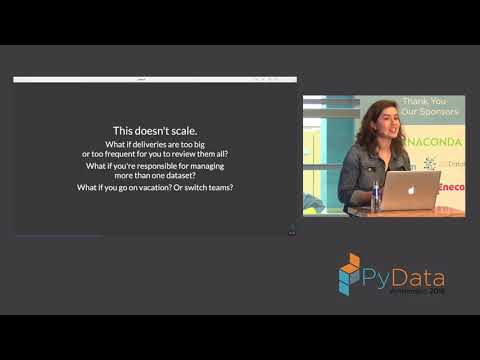

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('enlNiRSt9nk')